# Clustering
I will try different options to cluster the data and see what results I get

In [1]:
import math
import pandas as pandas
import numpy as np
import matplotlib
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from math import floor
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

data = pandas.read_json("../data/water_loss_data_set_1.json")

In [2]:
data = data[(data.timeStamp != "0000-00-00 00:00:00" ) & (data.timeStamp != "2000-01-01 00:00:00")] 
data = data[(data.tot1 != 0 ) & (data.analog2 != 0)]
data["timeStamp"] = pandas.to_datetime(data["timeStamp"], format="%Y-%m-%d %H:%M")

data["timeStamp"] = data["timeStamp"].dt.floor('h')
data["timeStamp"] = data["timeStamp"].dt.strftime("%Y-%m-%d %H:%M")
data["timeStamp"] = pandas.to_datetime(data["timeStamp"], format="%Y-%m-%d %H:%M")

data_249 = data[data['idflowmeter'] == "MAG8000_024905H318"]
data_248 = data[data['idflowmeter'] == "MAG8000_024805H318"]

data_249 = data_249.groupby("timeStamp").mean()
data_248 = data_248.groupby("timeStamp").mean()
data_248

,tot1,tot2,analog2
timeStamp,,,
2018-12-11 12:00:00,161.873400,0.00,0.819200
2018-12-11 13:00:00,264.282667,0.00,0.820333
2018-12-11 14:00:00,371.478000,0.00,0.818333
2018-12-11 15:00:00,487.519333,0.00,0.813167
2018-12-11 16:00:00,601.331833,0.00,0.810833
...,...,...,...
2020-04-01 10:00:00,977299.898333,-4713.21,1.527333
2020-04-01 11:00:00,977333.727167,-4713.21,1.528500
2020-04-01 12:00:00,977369.184833,-4713.21,1.530500


In [3]:
if type(data_249.index) == pandas.core.indexes.datetimes.DatetimeIndex:
    data_249.index = data_249.index.strftime("%Y-%m-%d %H:00")
    data_248.index = data_248.index.strftime("%Y-%m-%d %H:00")
    
# normalizacija
"""data_248 = ((data_248 - data_248.min()) / (data_248.max() - data_248.min()))
data_249 = ((data_249 - data_249.min()) / (data_249.max() - data_249.min()))
data_248"""

'data_248 = ((data_248 - data_248.min()) / (data_248.max() - data_248.min()))\ndata_249 = ((data_249 - data_249.min()) / (data_249.max() - data_249.min()))\ndata_248'

In [4]:
def selected_data(data_fun, start, end):
    return data_fun.loc[(data_fun.index >= start) & (data_fun.index <= end)]
    # "2020-01-20 00:00", "2020-01-24 23:00"
data_sel = selected_data(data_249, "2019-05-11 12:00:00", "2019-05-20 12:00:00")
data_all = selected_data(data_249, "2018-05-11 12:00:00", "2020-06-13 12:00:00")
data_sel

,tot1,tot2,analog2
timeStamp,,,
2019-05-11 13:00,222377.903000,-26.36,0.808500
2019-05-11 14:00,222445.629500,-26.36,0.807667
2019-05-11 15:00,222514.140667,-26.36,0.806667
2019-05-11 16:00,222579.802500,-26.36,0.803167
2019-05-11 17:00,222647.538833,-26.36,0.802000
...,...,...,...
2019-05-20 08:00,232064.267833,-66.81,0.807167
2019-05-20 09:00,232130.722500,-66.81,0.807333
2019-05-20 10:00,232190.397333,-66.81,0.811000


## Clustering pressure data 
**TODO**
1. Pridobi razrede
2. Ugotovi kje so krticicna stanje
3. Naredi da lohk zberes timeframe in zrise več grafov
**

In [5]:
matrix = data_sel.reset_index().values
matrix_X = matrix[:, 3:]             # try different variations of clustering, and with different attributes
# array_Y = matrix[:, 3:].ravel()
matrix_all = data_all.reset_index().values
matrix_X_all = matrix_all[:, 3:]             # try different variations of clustering, and with different attributes

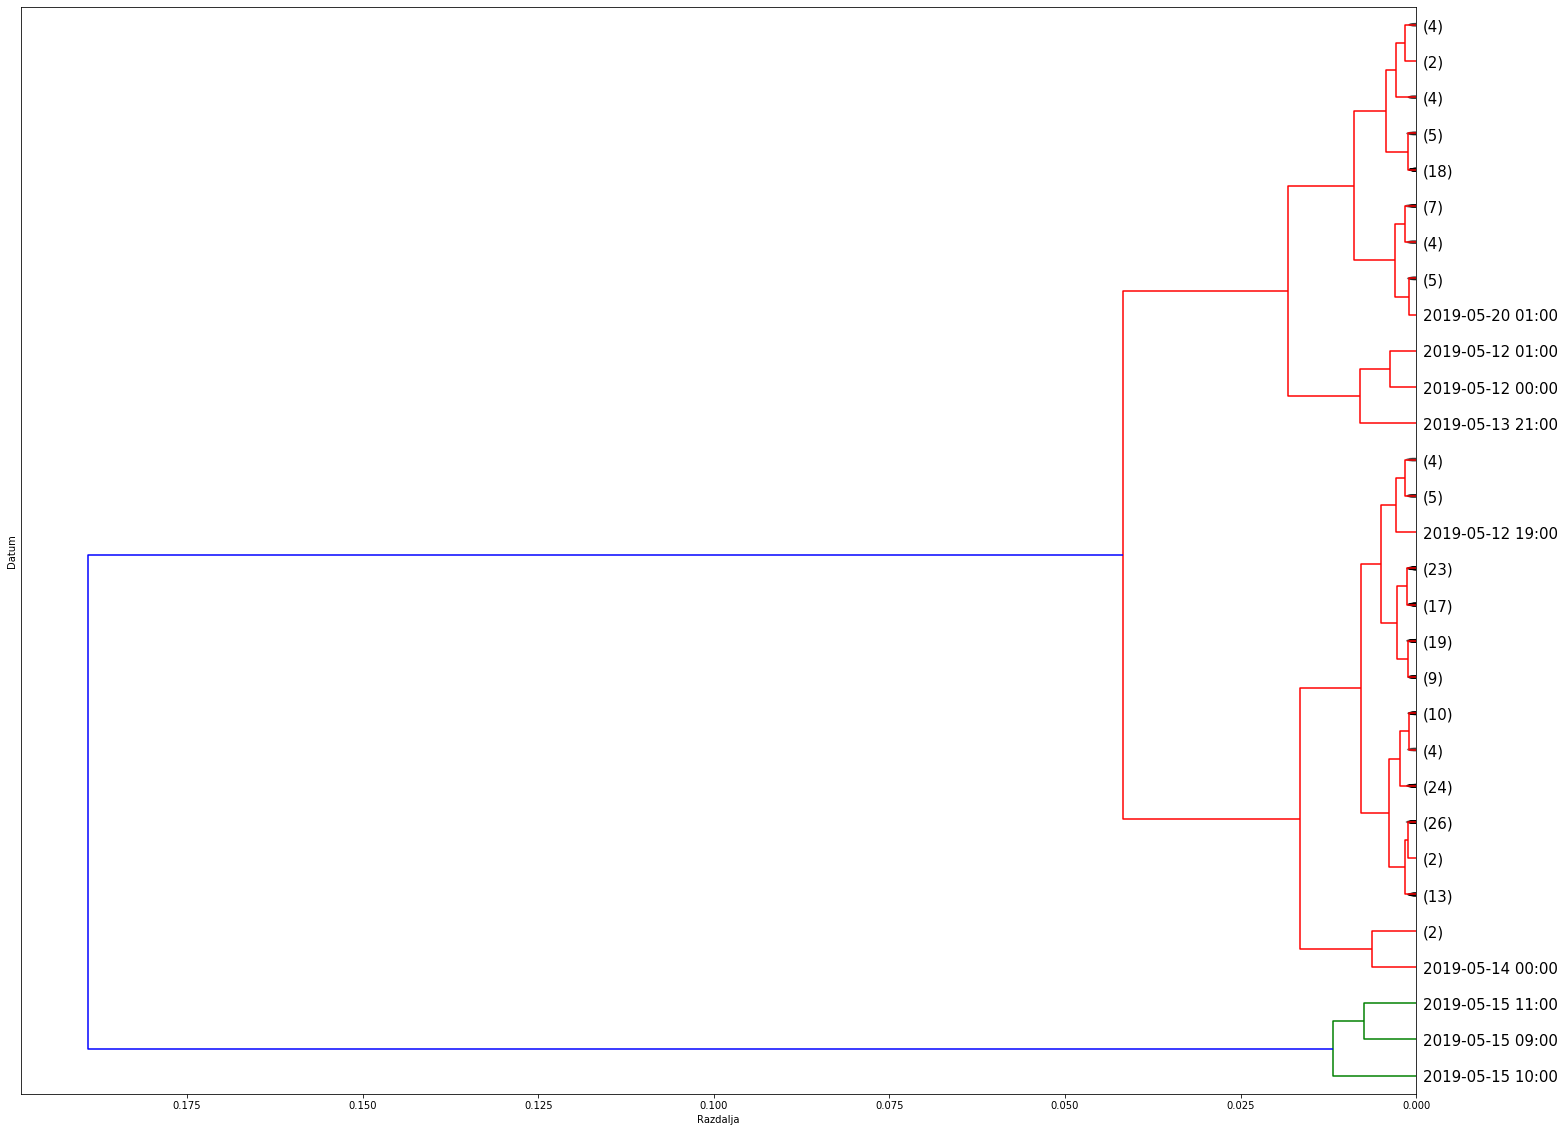

In [6]:
L = sch.linkage(matrix_X, method="average", metric="cityblock")
plt.figure(figsize=(25, 20))
D      = sch.dendrogram(L, leaf_font_size=15, labels=matrix[:, 0], orientation="left", 
                        show_contracted=True, 
                        truncate_mode='lastp',  # last p merged clusters
                        p=30                    # show only the last p merged clusters
                       )
plt.xlabel("Razdalja")
plt.ylabel("Datum")
plt.show()

In [7]:
# finding the best t depending on silhuete score (best value 1, worst -1)
max_silhuete = [-1, 0]
arr = []

max_val = floor(max(sch.maxdists(L)) * 100)/100.0
print(max_val)

for t_f in np.arange(max_val, 0.0, -0.0001):
    predictions = sch.fcluster(L, t=t_f, criterion="distance").ravel()
    score = round(silhouette_score(matrix_X, predictions, metric="cityblock"), 3)
    arr.append((score, t_f))
    if max_silhuete[0] < score:
        max_silhuete[0] = score
        max_silhuete[1] = t_f
        
print("The best value for t is t =", max_silhuete[1])
# print(arr)

0.18
The best value for t is t = 0.18


In [8]:
# find the distance at which to cut -> t= 0.0165 ?
t= 0.0165
predictions = sch.fcluster(L, t=t, criterion="distance").ravel()
# 4 classes

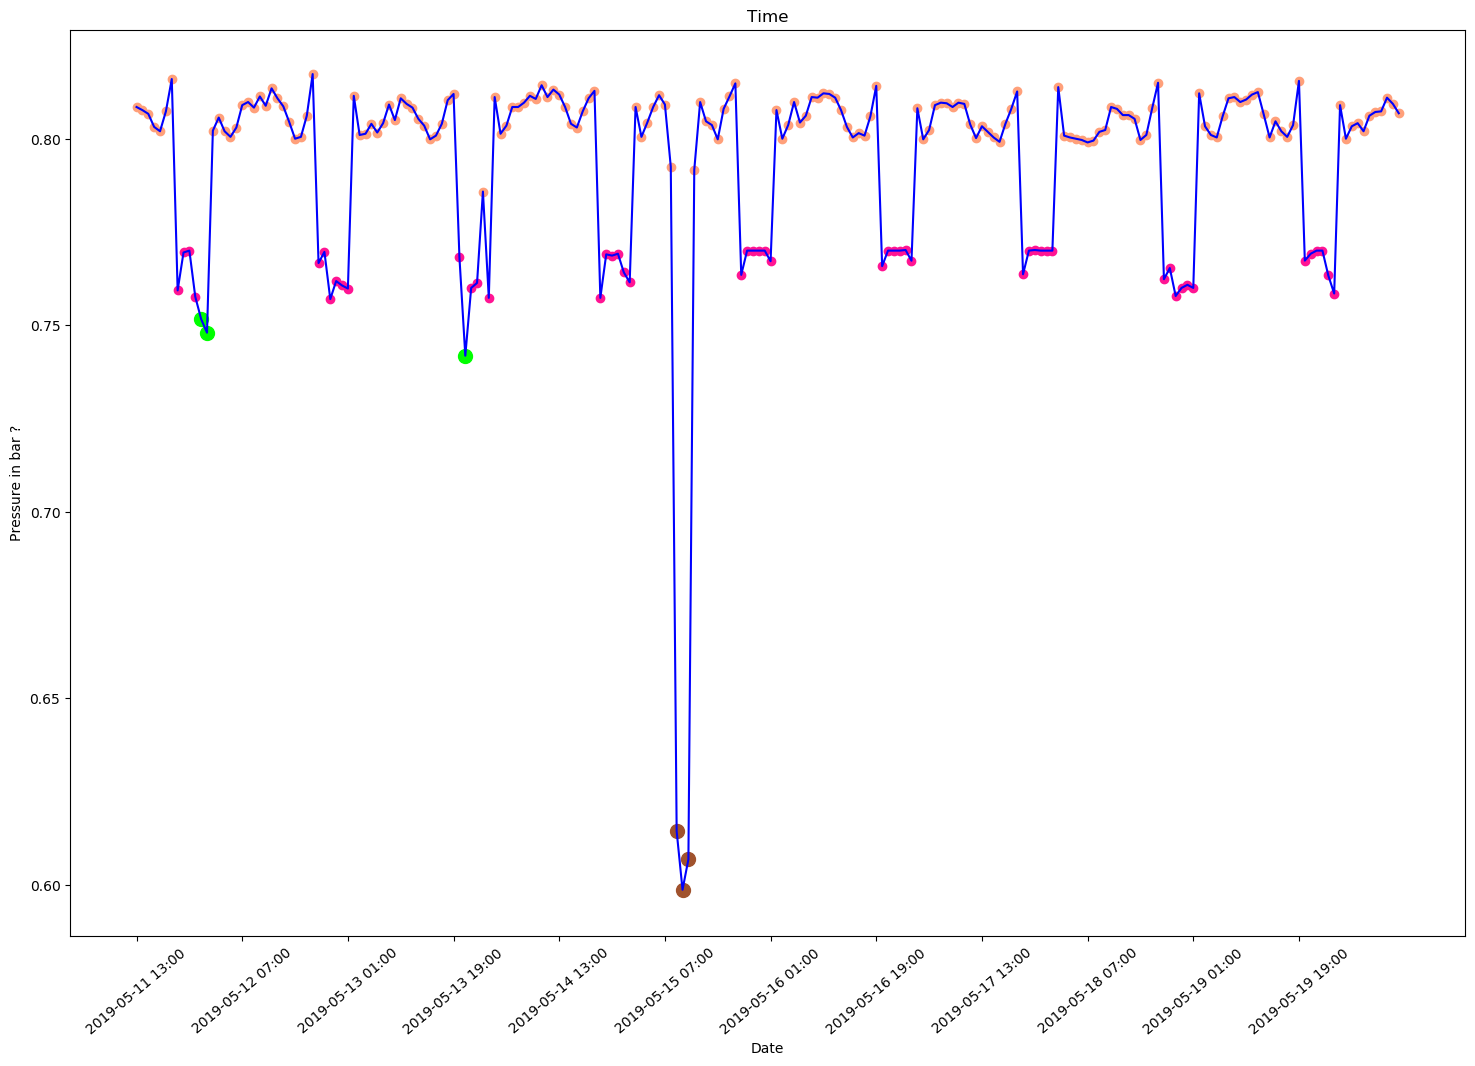

In [9]:
class_dict = dict()

for index, combined in enumerate(zip(matrix[:, 0], predictions)):
    value, predicted_class = combined
    if predicted_class not in class_dict:
        class_dict[predicted_class] = [(index, value)]
    else:
        class_dict[predicted_class].append((index, value))
    
def generate_timestamp_yaxis_array(matrix):
    fig = plt.figure(figsize=(18, 12), dpi= 100, facecolor='w')
    plt.plot(matrix[:, 0], matrix_X, color="blue")
    s_anomaly = 100
    
    plt.scatter([x[1] for x in class_dict[3]], [matrix_X[x[0]] for x in class_dict[3]], color='lime', s=s_anomaly) 
    plt.scatter([x[1] for x in class_dict[1]], [matrix_X[x[0]] for x in class_dict[1]], color='sienna', s=s_anomaly) 
    plt.scatter([x[1] for x in class_dict[4]], [matrix_X[x[0]] for x in class_dict[4]], color='deeppink') 
    plt.scatter([x[1] for x in class_dict[2]], [matrix_X[x[0]] for x in class_dict[2]], color='lightsalmon') 

    plt.ylabel('Pressure in bar ?')
    plt.xlabel('Date')
    plt.xticks([i for i in range(0,len(matrix), round(len(matrix)/12))], rotation=40)
    plt.rc('xtick',labelsize=8)
    plt.title('Time')
    # plt.savefig('blue_id.png')
    plt.show()
    
generate_timestamp_yaxis_array(matrix)    
# class_dict

In [10]:
# single pa cosine zelo dobro loči glede na graf
# ward tudi

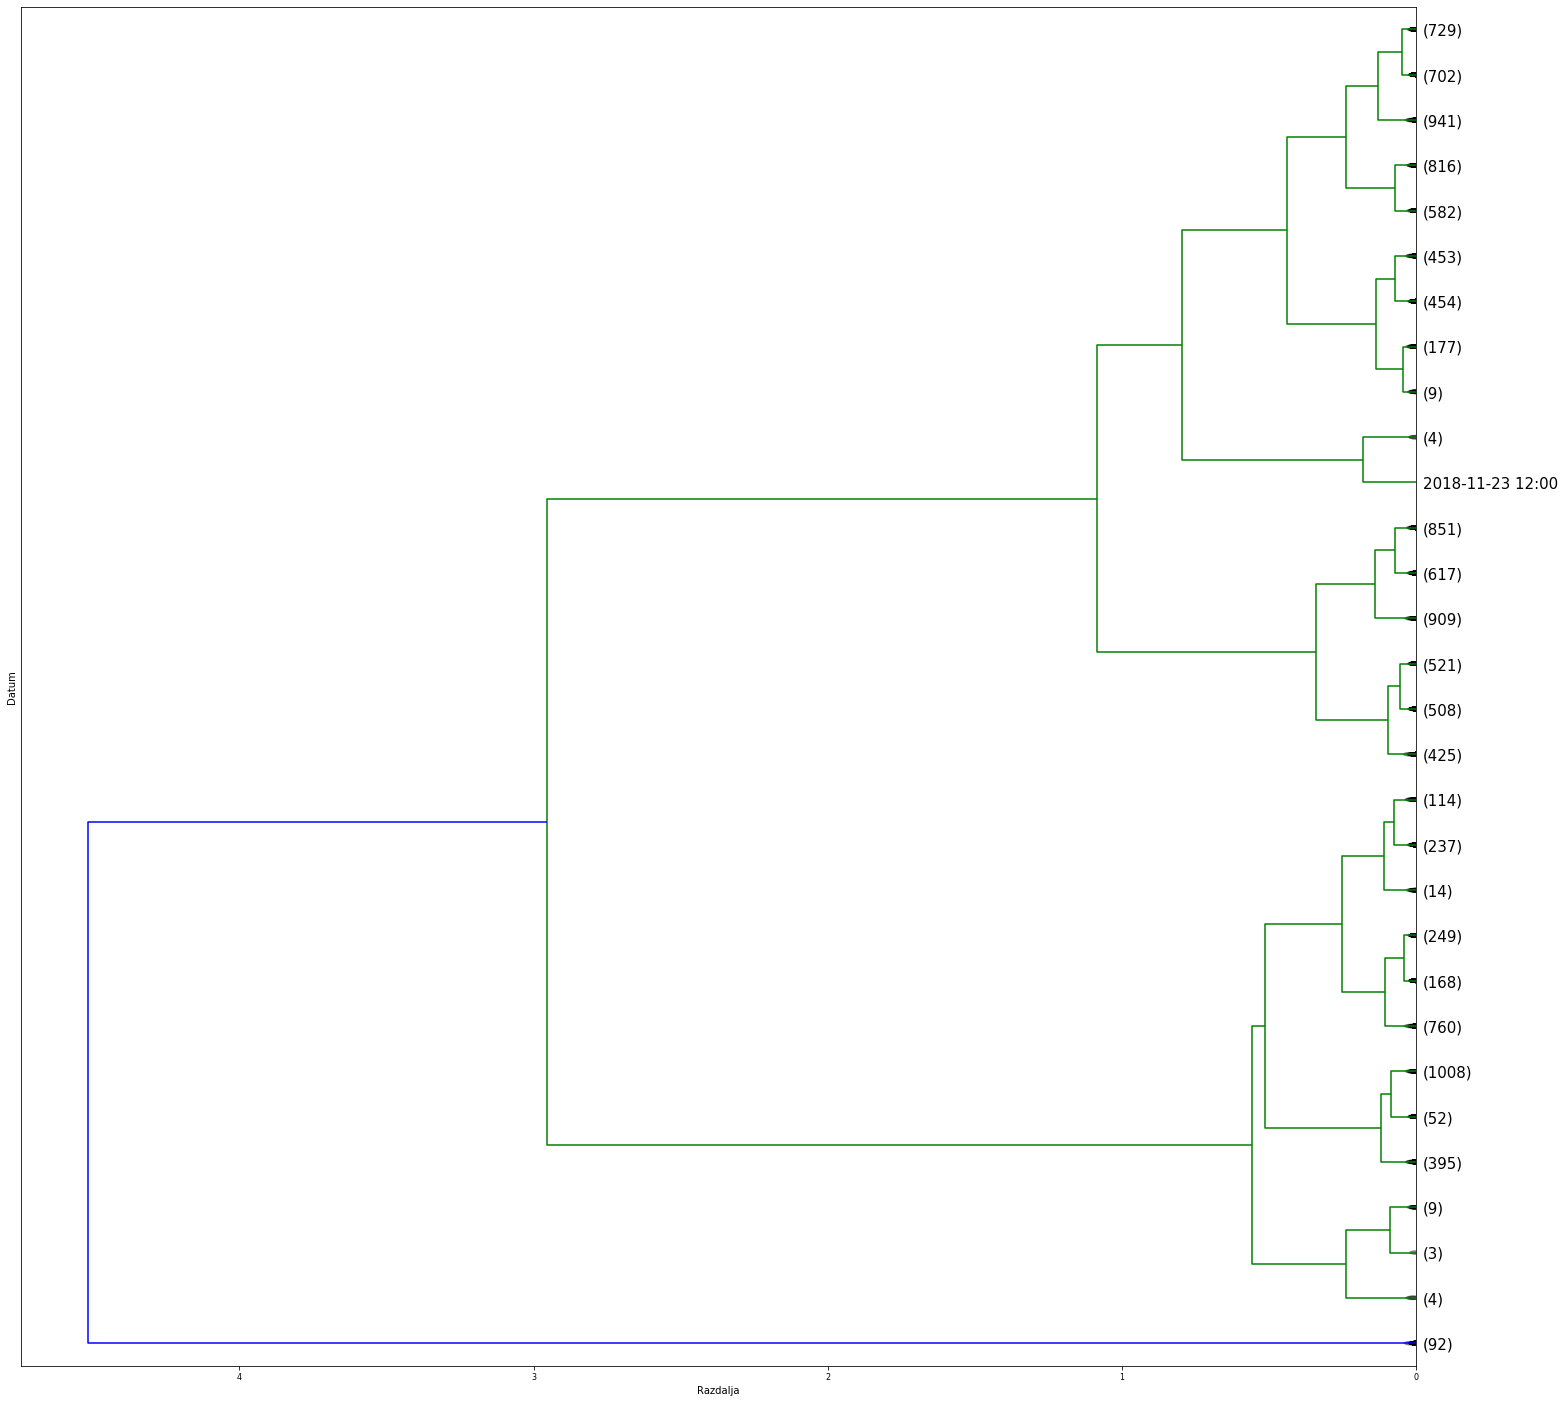

In [16]:
L_2 = sch.linkage(matrix_X_all, method="ward")
plt.figure(figsize=(25, 25))
# D      = sch.dendrogram(, leaf_font_size=15, labels=, orientation="left")
D      = sch.dendrogram(L_2, leaf_font_size=15, labels=matrix_all[:, 0], orientation="left", 
                        show_contracted=True, 
                        truncate_mode='lastp',  # last p merged clusters
                        p=30                    # show only the last p merged clusters
                       )
plt.xlabel("Razdalja")
# plt.yticks([])
plt.ylabel("Datum")
plt.show()

## Try out K-means and DBSCAN

## K-means
Looking at the lower graph k means should produce a good result

________________________________
Another thing you can and should definitely do is check the Cophenetic Correlation Coefficient of your clustering with help of the cophenet() function. This (very very briefly) compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances, which in our case is pretty close:  
  
```from scipy.cluster.hierarchy import cophenet```  
```from scipy.spatial.distance import pdist```
  
```c, coph_dists = cophenet(Z, pdist(X))```  
```c```   

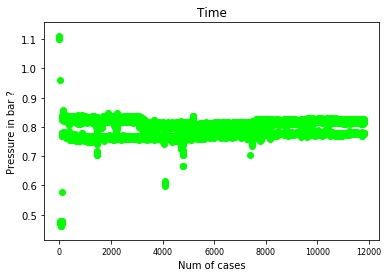

In [12]:
plt.scatter([i for i in range(len(matrix_X_all))], matrix_X_all, color='lime') 

plt.ylabel('Pressure in bar ?')
plt.xlabel('Num of cases')
plt.title('Time')
plt.show()

In [13]:
from sklearn.cluster import KMeans

kmeans5 = KMeans(n_clusters=7)
y_kmeans5 = kmeans5.fit_predict(matrix_X_all)
print(y_kmeans5)

kmeans5.cluster_centers_

[4 4 4 ... 1 1 1]


array([[0.76496065],
       [0.81796516],
       [0.47546507],
       [0.80532293],
       [1.10335771],
       [0.82833676],
       [0.77873061]])

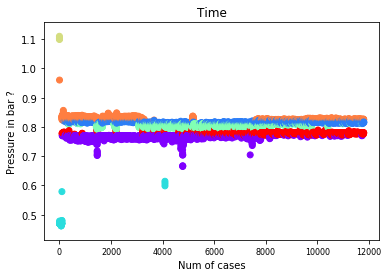

In [14]:
# find optimal k
plt.scatter([i for i in range(len(matrix_X_all))], matrix_X_all, c=y_kmeans5, cmap="rainbow") 

plt.ylabel('Pressure in bar ?')
plt.xlabel('Num of cases')
plt.title('Time')
plt.show()

## DBSCAN 
Trying out DBSCAN -> The solution was harder to implement and didn't produce requried results ....